In [31]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import copy 
import os
os.environ["PROJ_LIB"] = "C:\\ProgramData\\Anaconda3\\Library\\share";
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from scipy import optimize
import random
import numpy as np
from scipy.interpolate import Akima1DInterpolator
from sklearn import datasets, linear_model
import pickle
import matplotlib

levels = [0, 1, 2, 3, 4, 5]
colors = ['black', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
    
plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [32]:
# load test ensemble data
with open('test_data/2018_ensTest_48hrs.pickle', 'rb') as handle:
    ensemble_data = pickle.load(handle)
with open('test_data/2018_meanEnsTest_48hrs.pickle', 'rb') as handle:
    meanEnsTest_data = pickle.load(handle)
with open('test_data/2018_bestLabelTest_48hrs.pickle', 'rb') as handle:
    bestLabelTest_data = pickle.load(handle)

# initialization
ens_tn = ['AC00', 'AP01','AP02','AP03','AP04','AP05','AP06','AP07','AP08','AP09','AP10','AP11','AP12','AP13','AP14',
          'AP15','AP16','AP17','AP18','AP19','AP20']
ens_mean_tn = ['AEMN'] # ensemble mean track name
best_tn = ['BEST']

#forecast_periods = [0, 6, 12, 18, 24] # forecast horizon is 24hrs, and time step is 6 hrs, origin is from 6hrs
forecast_periods = [0, 6, 12, 18, 24, 30, 36, 42, 48] 

nens = len(ens_tn)
ntst = len(forecast_periods) # number of time steps. 6hrs is the time step for the GEFS forecasts.

In [48]:
%run egctf_main.ipynb

senFPr = 50e3 # sensor footprint radius in [m]

phase2_lastKnown_thresh = 48*60/60 # last time storm is seen in hours
timeSinceLastKnown = np.inf

wetp = 1 # confidence in ensemble velocity 

regr_seg_gap_hrs = 60/60
regr_subseg_length_hrs = regr_seg_gap_hrs # ISSUE: Not sure of behaviour if these two are not equal

_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2])
_ncov = np.array([10**2])

_obs_freq = np.arange(2,52,2)
NCOV, OBSFR = np.meshgrid(_ncov, _obs_freq)

In [36]:
ex = 4

ERROR = np.full(NCOV.shape, np.nan)

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', OBSFR[j,k])

        obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*OBSFR[j,k])
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (1km variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)        

        ERROR[j,k] = algo_results['error_wna']

        
with open('test_obs_freq_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ERROR, handle, protocol=pickle.HIGHEST_PROTOCOL)  
        


Case:  2
Case:  4
Case:  6
Case:  8
Case:  10
Case:  12
Case:  14
Case:  16
Case:  18
Case:  20
Case:  22
Case:  24
Case:  26
Case:  28
Case:  30
Case:  32
Case:  34
Case:  36
Case:  38
Case:  40
Case:  42
Case:  44
Case:  46
Case:  48
Case:  50


In [37]:
ex = 60

ERROR = np.full(NCOV.shape, np.nan)

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', OBSFR[j,k])

        obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*OBSFR[j,k])
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (1km variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)        

        ERROR[j,k] = algo_results['error_wna']

        
with open('test_obs_freq_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ERROR, handle, protocol=pickle.HIGHEST_PROTOCOL)  

Case:  2
Case:  4
Case:  6
Case:  8
Case:  10
Case:  12
Case:  14
Case:  16
Case:  18
Case:  20
Case:  22
Case:  24
Case:  26
Case:  28
Case:  30
Case:  32
Case:  34
Case:  36
Case:  38
Case:  40
Case:  42
Case:  44
Case:  46
Case:  48
Case:  50


In [38]:
ex = 121

ERROR = np.full(NCOV.shape, np.nan)

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', OBSFR[j,k])

        obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*OBSFR[j,k])
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (1km variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)        

        ERROR[j,k] = algo_results['error_wna']

        
with open('test_obs_freq_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ERROR, handle, protocol=pickle.HIGHEST_PROTOCOL)  

Case:  2
Case:  4
Case:  6
Case:  8
Case:  10
Case:  12
Case:  14
Case:  16
Case:  18
Case:  20
Case:  22
Case:  24
Case:  26
Case:  28
Case:  30
Case:  32
Case:  34
Case:  36
Case:  38
Case:  40
Case:  42
Case:  44
Case:  46
Case:  48
Case:  50


In [39]:
ex = 203

ERROR = np.full(NCOV.shape, np.nan)

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', OBSFR[j,k])

        obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*OBSFR[j,k])
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (1km variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)        

        ERROR[j,k] = algo_results['error_wna']

        
with open('test_obs_freq_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ERROR, handle, protocol=pickle.HIGHEST_PROTOCOL)  

Case:  2
Case:  4
Case:  6
Case:  8
Case:  10
Case:  12
Case:  14
Case:  16
Case:  18
Case:  20
Case:  22
Case:  24
Case:  26
Case:  28
Case:  30
Case:  32
Case:  34
Case:  36
Case:  38
Case:  40
Case:  42
Case:  44
Case:  46
Case:  48
Case:  50


In [40]:
ex = 249

ERROR = np.full(NCOV.shape, np.nan)

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', OBSFR[j,k])

        obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*OBSFR[j,k])
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (1km variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)        

        ERROR[j,k] = algo_results['error_wna']

        
with open('test_obs_freq_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ERROR, handle, protocol=pickle.HIGHEST_PROTOCOL)  

Case:  2
Case:  4
Case:  6
Case:  8
Case:  10
Case:  12
Case:  14
Case:  16
Case:  18
Case:  20
Case:  22
Case:  24
Case:  26
Case:  28
Case:  30
Case:  32
Case:  34
Case:  36
Case:  38
Case:  40
Case:  42
Case:  44
Case:  46
Case:  48
Case:  50


In [9]:
## Visualize Results

<IPython.core.display.Javascript object>


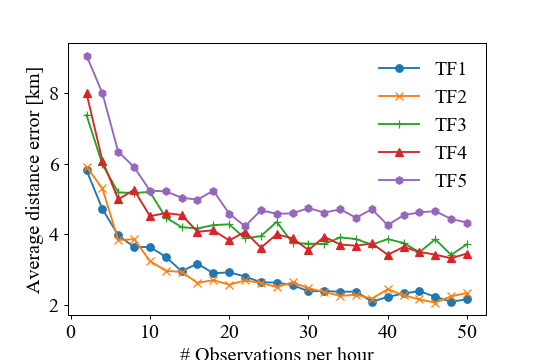

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100]
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100]


In [50]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x = len(_ncov)-1

plt.figure()

with open('results/test_obs_freq_ex4.pickle', 'rb') as handle:
    ERROR = pickle.load(handle)
plt.plot(OBSFR[:,x], ERROR[:,x], 'o', linestyle = '-')

with open('results/test_obs_freq_ex60.pickle', 'rb') as handle:
    ERROR = pickle.load(handle)
plt.plot(OBSFR[:,x], ERROR[:,x], 'x', linestyle = '-')

with open('results/test_obs_freq_ex121.pickle', 'rb') as handle:
    ERROR = pickle.load(handle)
plt.plot(OBSFR[:,x], ERROR[:,x], '+', linestyle = '-')

with open('results/test_obs_freq_ex203.pickle', 'rb') as handle:
    ERROR = pickle.load(handle)
plt.plot(OBSFR[:,x], ERROR[:,x], '^', linestyle = '-')

with open('results/test_obs_freq_ex249.pickle', 'rb') as handle:
    ERROR = pickle.load(handle)
plt.plot(OBSFR[:,x], ERROR[:,x], 'h', linestyle = '-')

print(NCOV[:,x])

plt.xlabel('# Observations per hour')
plt.ylabel('Average distance error [km]')
plt.legend(['TF1', 'TF2', 'TF3', 'TF4', 'TF5'], frameon=False)
#plt.xticks(OBSFR[:,x])
plt.show();
print(NCOV[:,x])
plt.savefig("error_vs_obs_frequency.svg")

In [12]:
OBSFR.shape

(9, 14)

In [13]:
NCOV.shape

(9, 14)

In [14]:
ERROR.shape

(9, 14)

<IPython.core.display.Javascript object>


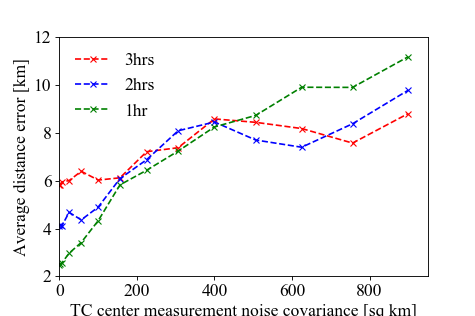

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [26]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ex = [4, 60, 121, 203, 249 ]
_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2])
_ssglen = 1/60 * np.array([30, 37.5, 45, 52.5, 60, 67,5, 75, 82.5, 90, 97.5, 105, 112.5, 120, 127.5, 135, 142.5, 
                           150, 157.5, 165, 172.5, 180])
NCOV, SSGLEN = np.meshgrid(_ncov, _ssglen)


with open('results/test_noise_vs_subseglen_ex4.pickle', 'rb') as handle:
    ERROR = pickle.load(handle)
    
plt.figure()
x = len(_ssglen)-1
plt.plot(NCOV[x,:], ERROR[x,:], 'rx--')
print(SSGLEN[x,:])

x = len(_ssglen)-9 
plt.plot(NCOV[x,:], ERROR[x,:], 'bx--')
print(SSGLEN[x,:])

x = len(_ssglen)-18
plt.plot(NCOV[x,:], ERROR[x,:], 'gx--')
print(SSGLEN[x,:])

plt.xlabel('TC center measurement noise covariance [sq km]')
plt.ylabel('Average distance error [km]')

plt.xlim((0,950))
plt.ylim((2,12))
plt.legend(['3hrs', '2hrs', '1hr'], frameon = False)
plt.show();
plt.savefig("error_vs_noise.svg")

In [16]:
ERROR.shape

(22, 14)